In [2]:
!pip install graphviz


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [1]:
import math
from graphviz import Digraph

In [2]:

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root, label=True):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    if label:
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    else:
        dot.node(name = uid, label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [9]:

class Value:

    def __init__(self, data, _prev=(), label='', _op=''):
        self._prev = _prev
        self.data = data
        self.label = label
        self._op = _op
        self.grad = 0
        self._backward = lambda: None

    def __repr__(self):
        return f'data={self.data}'

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, _prev=(self, other), _op='+')

        '''
        c = a + b
        dl/da = dl/dc * dc/da
        '''
        def _backward():
            self.grad += out.grad * 1
            other.grad += out.grad * 1

        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, _prev=(self, other), _op='*')

        '''
        c = a * b
        dl/da = dl/dc * dc/da
        '''
        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data

        out._backward = _backward
        return out

    def __sub__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data - other.data, (self, other), _op='-')
        def _backward():
            self.grad  +=  1.0 * out.grad
            other.grad += -1.0 * out.grad
        out._backward = _backward
        return out
    
    def __truediv__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data / other.data, (self, other), _op='/')
        def _backward():
            self.grad  += (1.0 / other.data) * out.grad
            other.grad += (-self.data / (other.data ** 2.0)) * out.grad
        out._backward = _backward
        return out
    
    
    def __pow__(self, n):
        if isinstance(n, Value):
            raise TypeError("n должно быть числом")
        n = float(n)
        out = Value(self.data ** n, (self,), _op=f'**{n}')
        def _backward():
            if self.data == 0.0 and n < 1.0:
                local = 0.0
            else:
                local = n * (self.data ** (n - 1.0))
            self.grad += local * out.grad
        out._backward = _backward
        return out

    def relu(self):
        out = Value(self.data if self.data > 0 else 0, (self,), _op='relu')
        
        def _backward():
            self.grad += (1.0 if self.data > 0.0 else 0.0) * out.grad
        out._backward = _backward
        return out
    
    def sigmoid(self) -> 'Value':
        s = 1.0 / (1.0 + math.exp(-self.data))
        out = Value(s, (self,), _op='sigmoid')
        def _backward():
            self.grad += (s * (1.0 - s)) * out.grad
        out._backward = _backward
        return out


    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [4]:
w1 = Value(2, label='w1')
w2 = Value(4, label='w2')
w3 = w1 + w2
w3.label = 'w3'
w4 = Value(5, label='w4')
L = w4 * w3
L.label = 'L'
L

data=30

-, /, pow, relu, sigmoid

In [25]:
x = Value(1.5, label='x')
y = Value(-0.5, label='y')

a = (x - y) / (x + y + 1.0)        # -, /
a.label = 'a'
b = (x ** 3.0) - (y ** 2.0)        # pow, -
b.label = 'b'
u = a * b
u.label = 'u'
c = u.relu()                 # *, relu
c.label = 'c'
v = x / y
v.label = 'v'
d = v.sigmoid()              # /, sigmoid
d.label = 'd'
w = (x - y) ** 2.0 + 0.5
w.label = 'w'
L = (c - d) / w

L.label = 'L'

for i in (x, y, a, b, c, d, L):
    i.grad = 0

L.backward()

In [15]:
L.backward()


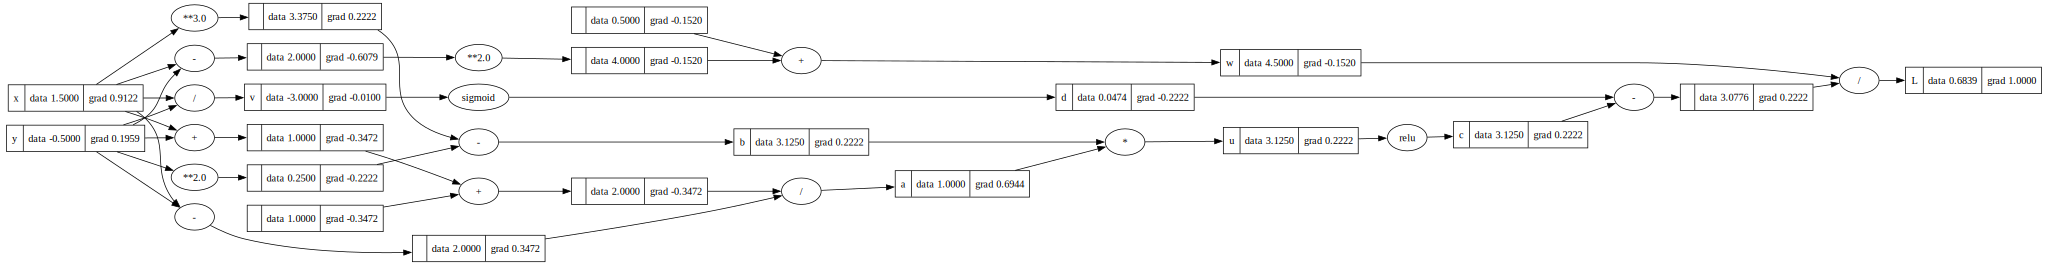

In [26]:
draw_dot(L)

Аналитически посчитаем производные:
L = (c - d) / ((x - y) ** 2.0 + 0.5)

dL/dc = 1 / ((x - y) ** 2.0 + 0.5) = 0.22222

dL/dd = -0.22222

dL/d((x - y) ** 2.0 + 0.5) = -(c - d) / ((x - y) ** 2.0 + 0.5) ** 2 = -0.1519


Можно заметить, что на этих числах уже получаем значения, приближенные к тем, что мы посчитали с помощью AutoGrad


c = Relu(u)

dc/du = 1, u > 0 => gu += gc * 1 = 0.22222


d = sigm(v)

gv += gd * d(1 - d) = -0.22222 * 0.0474 * (1 - 0.0474) = -0.01
...

## Вывод
Метод автоматического диффиринцирования успешно показал себя при подсчете градиентов каждой ноды графа